# Kaggle: Store Item Demand Forecasting Challenge

Kaggle [Store Item Demand Forecasting Challenge][kaggle] コンペの中の、
Kaggle Notebooks [My First Time Series Comp (Added Prophet)][adityaecdrid] を見ながら
データセットを確認します。
主に "Few Pivoted Plots" の章に書かれている基本的なデータセットの確認までを対象としています。

[kaggle]: https://www.kaggle.com/c/demand-forecasting-kernels-only/overview
[adityaecdrid]: https://www.kaggle.com/adityaecdrid/my-first-time-series-comp-added-prophet


## パッケージの追加

In [1]:
!pip install kaggle

## Import

In [0]:
# default packages
import logging
import pathlib
import re

In [3]:
# third party packages
import google.colab.drive as drive
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# auto reload
%load_ext autoreload
%autoreload 2

In [0]:
# graph settigns
sns.set()

In [0]:
# logger
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

## フォルダ構成の生成

In [0]:
data_dir = pathlib.Path("data")
raw_dir = data_dir.joinpath("raw")

data_dir.mkdir(exist_ok=True)
raw_dir.mkdir(exist_ok=True)

## Google Drive のマウント


In [8]:
def mount_gdrive() -> pathlib.Path:
    """Google Drive をマウントし、必要なディレクトリへのシンボリックリンクを設定する."""
    gdrive_base = pathlib.Path("/content/drive")
    gdrive_cache = gdrive_base.joinpath("My Drive/storeItemDemandForecastingChallenge")
    gdrive_kaggle = gdrive_base.joinpath("My Drive/kaggle")

    kaggle_dir = pathlib.Path("./kaggle")
    cache_dir = pathlib.Path("./cache")

    if gdrive_base.exists() is False:
        drive.mount(str(gdrive_base))
    if cache_dir.exists() is False:
        !ln -s "$gdrive_cache" "$cache_dir"
    if kaggle_dir.exists() is False:
        !ln -s "$gdrive_kaggle" "$kaggle_dir"

    return cache_dir, kaggle_dir


cache_dir, kaggle_dir = mount_gdrive()

ln: failed to create symbolic link 'cache': File exists


## Kaggle API の有効化

In [0]:
def activate_kaggle_api(gdrive_kaggle: pathlib.Path) -> None:
    """Kaggle API を有効化するための token を Google Drive からコピーする."""
    kaggle_file = "kaggle.json"
    gdrive_kaggle_json = gdrive_kaggle.joinpath(kaggle_file)
    local_kaggle_dir = pathlib.Path("/root/.kaggle")
    local_kaggle_json = local_kaggle_dir.joinpath(kaggle_file)

    local_kaggle_dir.mkdir(exist_ok=True)
    !cp "$gdrive_kaggle_json" "$local_kaggle_json"
    !chmod 600 "$local_kaggle_json"


activate_kaggle_api(kaggle_dir)

## データセットの読み込み

In [10]:
!kaggle competitions download -c demand-forecasting-kernels-only -p "$raw_dir"

train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
df_raw = pd.read_csv(raw_dir.joinpath("train.csv.zip"), low_memory=False, parse_dates=["date"], index_col=["date"])
df_test = pd.read_csv(raw_dir.joinpath("test.csv"), low_memory=False, parse_dates=["date"], index_col=["date"])
df_subs = pd.read_csv(raw_dir.joinpath("sample_submission.csv"))

In [12]:
display.display(df_raw.info())
display.display(df_raw.head())
display.display(df_raw.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB


None

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


,store,item,sales
date,,,
2017-12-27,10,50,63
2017-12-28,10,50,59
2017-12-29,10,50,74
2017-12-30,10,50,62
2017-12-31,10,50,82


In [13]:
display.display(df_test.info())
display.display(df_test.head())
display.display(df_test.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45000 entries, 2018-01-01 to 2018-03-31
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      45000 non-null  int64
 1   store   45000 non-null  int64
 2   item    45000 non-null  int64
dtypes: int64(3)
memory usage: 1.4 MB


None

,id,store,item
date,,,
2018-01-01,0,1,1
2018-01-02,1,1,1
2018-01-03,2,1,1
2018-01-04,3,1,1
2018-01-05,4,1,1


,id,store,item
date,,,
2018-03-27,44995,10,50
2018-03-28,44996,10,50
2018-03-29,44997,10,50
2018-03-30,44998,10,50
2018-03-31,44999,10,50


In [14]:
display.display(df_subs.info())
display.display(df_subs.head())
display.display(df_subs.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      45000 non-null  int64
 1   sales   45000 non-null  int64
dtypes: int64(2)
memory usage: 703.2 KB


None

,id,sales
0,0,52
1,1,52
2,2,52
3,3,52
4,4,52


,id,sales
44995,44995,52
44996,44996,52
44997,44997,52
44998,44998,52
44999,44999,52


## 集約して推移を確認

In [15]:
def add_datepart(df_target: pd.DataFrame) -> pd.DataFrame:
    """日付に関する情報を付与した列を追加する."""
    date_series = df_target.index.to_series()
    attr = [
        "Year",
        "Month",
        "Week",
        "Day",
        "Dayofweek",
        "Dayofyear",
        "weekofyear",
        "Is_month_end",
        "Is_month_start",
        "Is_quarter_end",
        "Is_quarter_start",
        "Is_year_end",
        "Is_year_start"
    ]
    
    df = df_target.copy()
    for name in attr: 
        df[name] = getattr(date_series.dt, name.lower())

    return df


df_datepart = add_datepart(df_raw)
display.display(df_datepart.head())

,store,item,sales,Year,Month,Week,Day,Dayofweek,Dayofyear,weekofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
date,,,,,,,,,,,,,,,,
2013-01-01,1,1,13,2013,1,1,1,1,1,1,False,True,False,True,False,True
2013-01-02,1,1,11,2013,1,1,2,2,2,1,False,False,False,False,False,False
2013-01-03,1,1,14,2013,1,1,3,3,3,1,False,False,False,False,False,False
2013-01-04,1,1,13,2013,1,1,4,4,4,1,False,False,False,False,False,False
2013-01-05,1,1,10,2013,1,1,5,5,5,1,False,False,False,False,False,False


Year,2013,2014,2015,2016,2017
Week,,,,,
1,29.767250,34.808500,38.422000,38.367429,40.032000
2,29.686286,33.889714,35.581429,38.535429,39.971714
3,29.414286,33.913143,35.430286,38.389429,39.975429
4,29.513714,34.041714,35.497143,38.447714,39.812857
5,31.150571,35.318000,36.080857,42.600857,43.261429


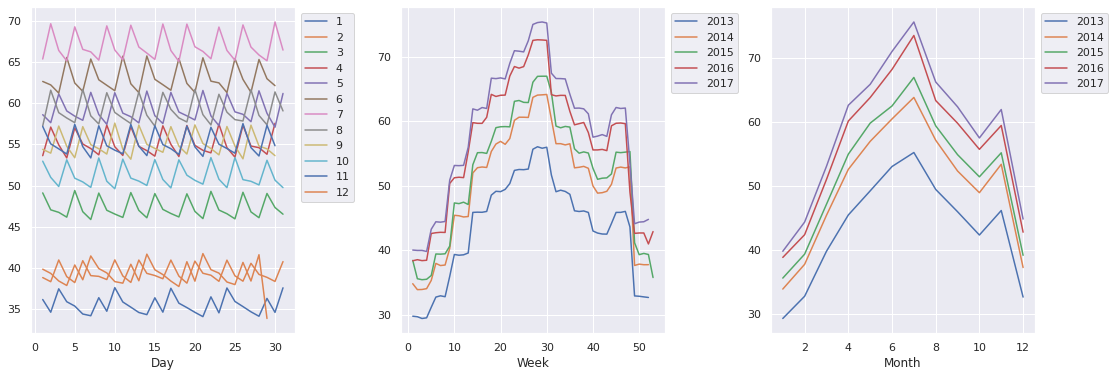

In [16]:
def plot_sales_pivot_table(df_target: pd.DataFrame) -> None:
    """全体で月と週、日での推移をプロットする."""
    daily = pd.pivot_table(df_target, values="sales", columns="Month", index="Day")
    weekly = pd.pivot_table(df_target, values="sales", columns="Year", index="Week")
    monthly = pd.pivot_table(df_target, values="sales", columns="Year", index="Month")
    display.display(weekly.head())

    rows, cols = 1, 3
    _, axes = plt.subplots(rows, cols, figsize=(18, 6))
    plt.subplots_adjust(wspace=0.4, hspace=0.6)
    daily.plot(ax=axes[0])
    axes[0].legend(bbox_to_anchor=(1, 1), loc=2)
    weekly.plot(ax=axes[1])
    axes[1].legend(bbox_to_anchor=(1, 1), loc=2)
    monthly.plot(ax=axes[2])
    axes[2].legend(bbox_to_anchor=(1, 1), loc=2)
    plt.show()
    plt.cla()
    plt.clf()
    plt.close()


plot_sales_pivot_table(df_datepart)

INFO:__main__:store index: 1


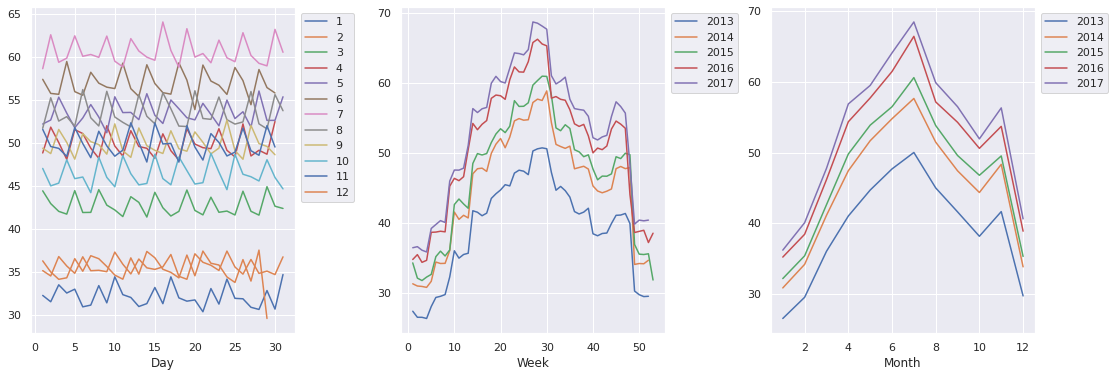

INFO:__main__:store index: 2


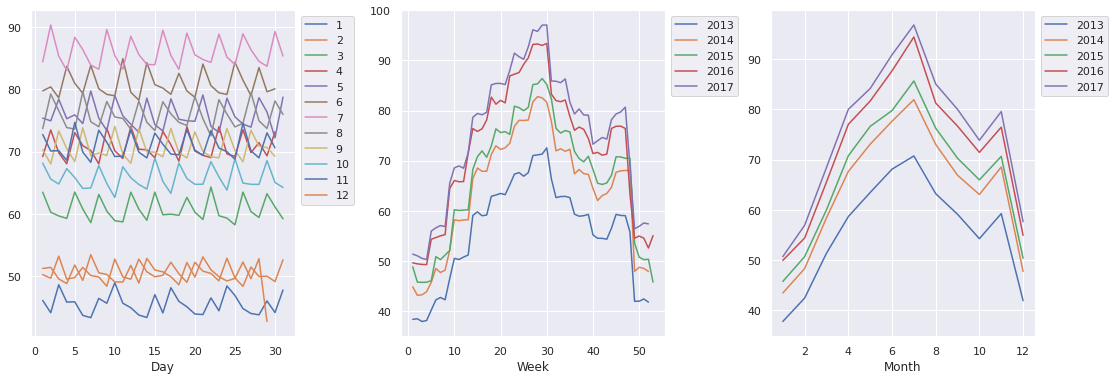

INFO:__main__:store index: 3


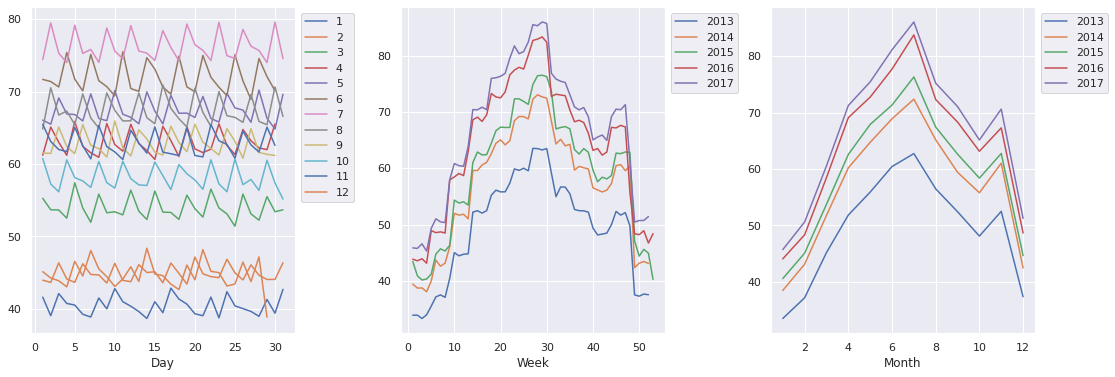

INFO:__main__:store index: 4


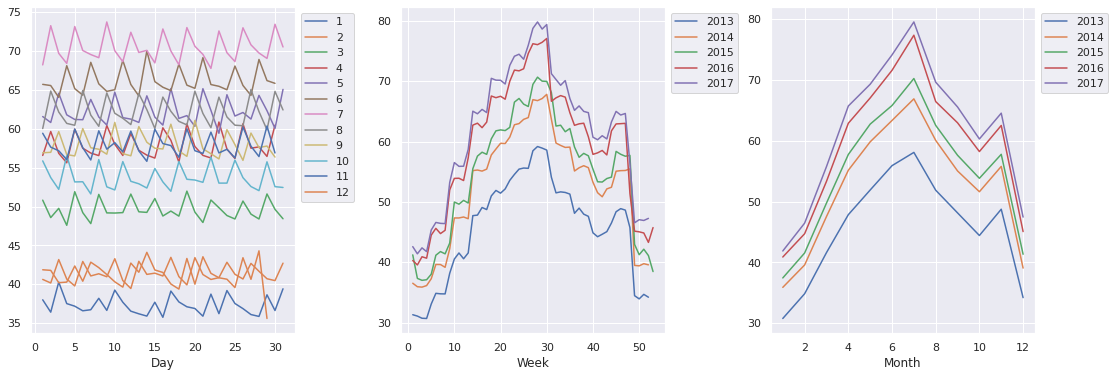

INFO:__main__:store index: 5


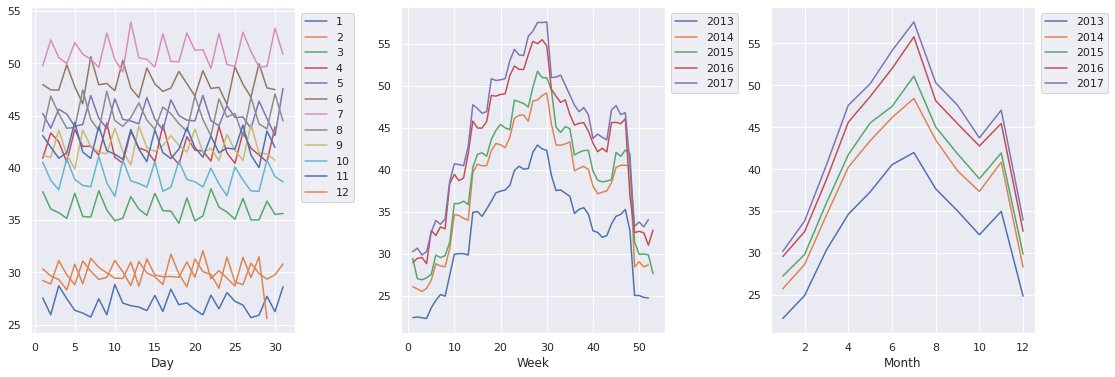

INFO:__main__:store index: 6


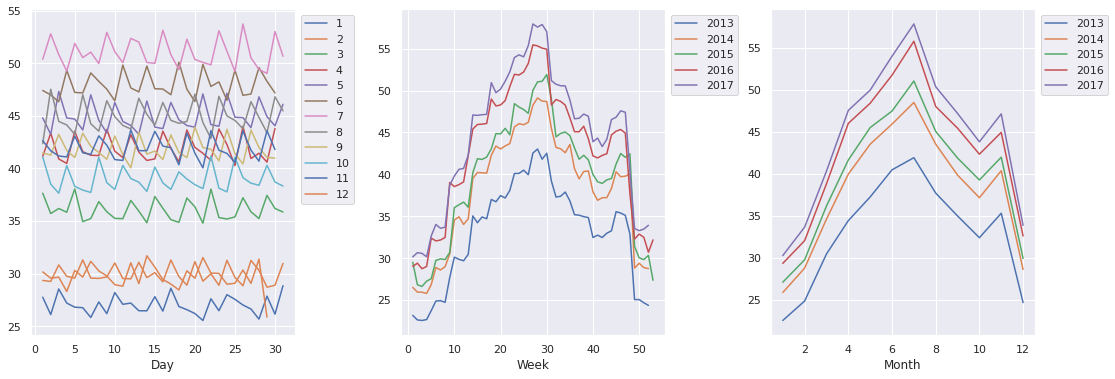

INFO:__main__:store index: 7


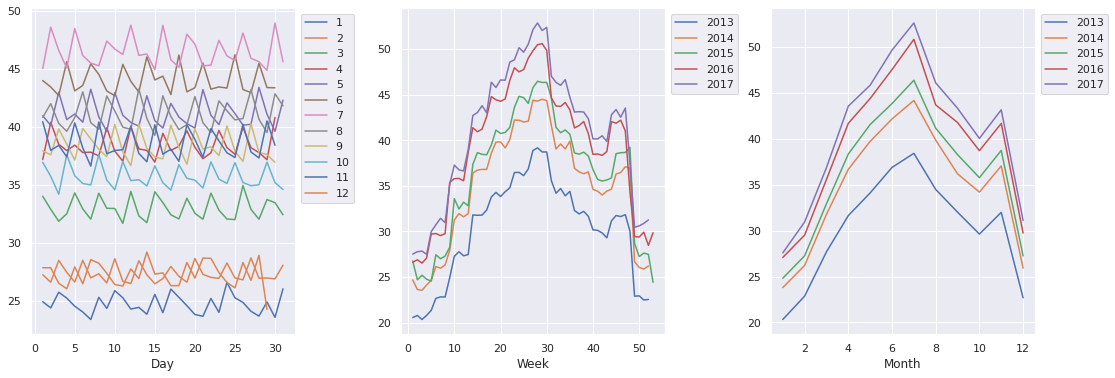

INFO:__main__:store index: 8


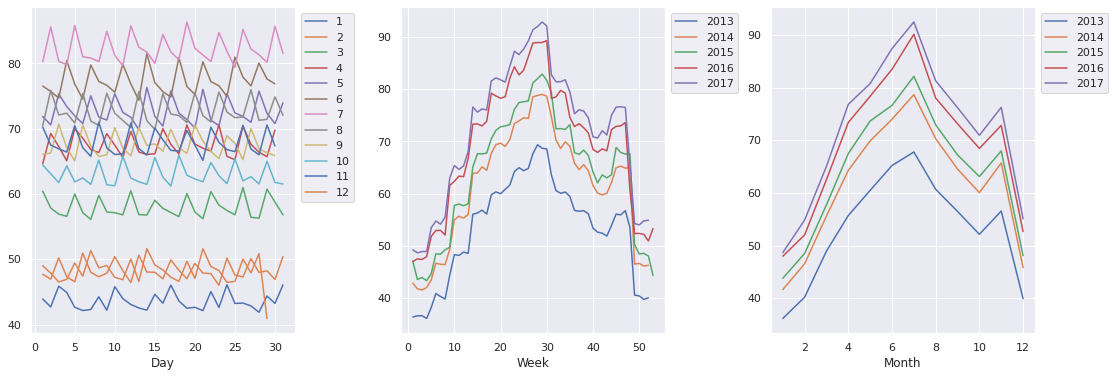

INFO:__main__:store index: 9


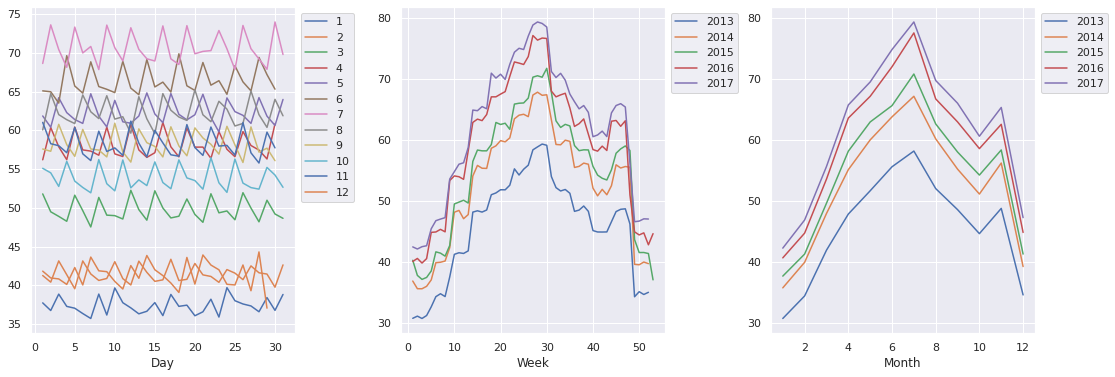

In [17]:
def plot_store_sales_pivot_table(
    df_target: pd.DataFrame,
    store_index: int
) -> None:
    """ストア単位での月と週の推移をプロットする."""
    logger.info(f"store index: {store_index}")

    df = df_target.groupby(["store"]).get_group(store_index)
    daily = pd.pivot_table(df, values="sales", columns="Month", index="Day")
    weekly = pd.pivot_table(df, values="sales", columns="Year", index="Week")
    monthly = pd.pivot_table(df, values="sales", columns="Year", index="Month")

    rows, cols = 1, 3
    _, axes = plt.subplots(rows, cols, figsize=(18, 6))
    plt.subplots_adjust(wspace=0.4, hspace=0.6)

    daily.plot(ax=axes[0])
    axes[0].legend(bbox_to_anchor=(1, 1), loc=2)
    weekly.plot(ax=axes[1])
    axes[1].legend(bbox_to_anchor=(1, 1), loc=2)
    monthly.plot(ax=axes[2])
    axes[2].legend(bbox_to_anchor=(1, 1), loc=2)

    plt.show()
    plt.cla()
    plt.clf()
    plt.close()


for idx in range(1, 10):
    plot_store_sales_pivot_table(df_datepart, idx)

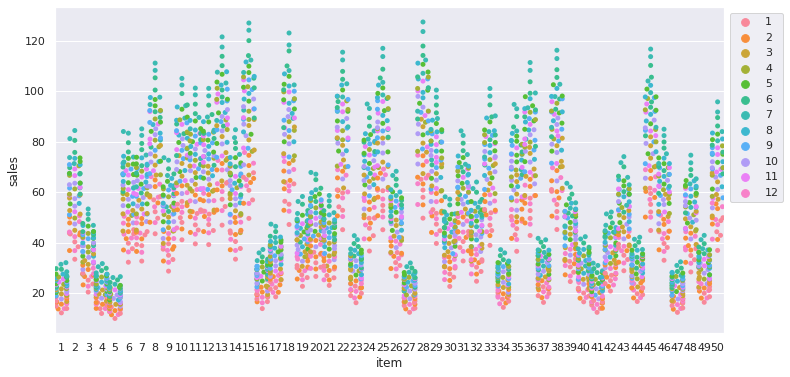

In [18]:
def swarmplot_month(df_target: pd.DataFrame) -> None:
    """月単位でのアイテムごとの sales をプロット."""
    df = df_target.groupby(["Year", "Month", "item"])["sales"].mean().reset_index()

    plt.figure(figsize=(12, 6))
    sns.swarmplot("item", "sales", data=df, hue="Month")
    plt.legend(bbox_to_anchor=(1, 1), loc=2)


swarmplot_month(df_datepart)